In [4]:
!pip install -qU sentence-transformers            # safe-guard: make sure SBERT is present

ERROR: Invalid requirement: '#'


In [27]:
# the %pip magic installs into the same env as the notebook kernel
%pip install -qU sentence-transformers datasets torch ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [51]:
import pandas as pd
import os, glob
import torch
from sentence_transformers import SentenceTransformer, util, models
from datasets import load_dataset
from sentence_transformers.evaluation import InformationRetrievalEvaluator, SequentialEvaluator
from sentence_transformers.util import cos_sim
import pickle

In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [30]:
#from google.colab import drive
#drive.mount('/content/drive')
file_path = r"C:\Users\user\Documents\MsThesis\\Output_preproc_model\exploded_df.csv"

In [59]:
#file_path = "/content/drive/Shareddrives/Master_Thesis/exploded_df.csv"   # adjust if your file is in a different folder
df = pd.read_csv(file_path)

In [60]:
df

,Unnamed: 0,id,title,categories,type,content
0,0,2501.00724,category o for quantum loop algebras,math.rt math.qa,theorems,\label{thm:main}\n\t\nConsider any Kac-Moody L...
1,1,2501.00724,category o for quantum loop algebras,math.rt math.qa,theorems,\label{thm:my refined}\n\nLet $\fg$ be of fini...
2,2,2501.00724,category o for quantum loop algebras,math.rt math.qa,theorems,\label{thm:toroidal}\n\nFor a polynomial $\ell...
3,3,2501.00724,category o for quantum loop algebras,math.rt math.qa,theorems,\label{thm:simple}\n\n(\cite{HJ}) Up to isomor...
4,4,2501.00724,category o for quantum loop algebras,math.rt math.qa,theorems,\label{thm:quantum to shuffle}\n\nWe have $\em...
...,...,...,...,...,...,...
182140,182140,2504.01046,denoising guarantees for optimized sampling sc...,stat.ml cs.it cs.lg eess.sp math.it math.pr,definitions,[Unit truncation]\n\label{loc:unit_truncation....
182141,182141,2504.01046,denoising guarantees for optimized sampling sc...,stat.ml cs.it cs.lg eess.sp math.it math.pr,definitions,[Restricted Isometry Property]\n\label{loc:rip...
182142,182142,2504.01046,denoising guarantees for optimized sampling sc...,stat.ml cs.it cs.lg eess.sp math.it math.pr,definitions,[Sampling complexity function]\n\label{loc:wit...
182143,182143,2504.01046,denoising guarantees for optimized sampling sc...,stat.ml cs.it cs.lg eess.sp math.it math.pr,definitions,"[(k,d,n)-Generative neural network~{\cite[Defi..."


Consider small sample

In [61]:
# Take only 5 unique papers
sample_ids = df['id'].drop_duplicates().sample(n=5, random_state=42)
df = df[df['id'].isin(sample_ids)]

In [62]:
# 1. Convert ID column to string
df['id'] = df['id'].astype(str)
df['temp_id'] = df.groupby('id').cumcount().astype(str)

C:\Users\user\AppData\Local\Temp\ipykernel_26324\1396146947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id'] = df['id'].astype(str)
C:\Users\user\AppData\Local\Temp\ipykernel_26324\1396146947.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_id'] = df.groupby('id').cumcount().astype(str)


In [63]:
# 3. Handle NaN values in type column
df['type'] = df['type'].fillna('unk')

C:\Users\user\AppData\Local\Temp\ipykernel_26324\2804557818.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['type'].fillna('unk')


In [64]:
# 4. Create content_id using proper string conversion
df['content_id'] = (
    df['id'] + '_' +
    df['type'].str[:3] +
    '_' +  # Added separator for clarity
    df['temp_id']
)

C:\Users\user\AppData\Local\Temp\ipykernel_26324\295671577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content_id'] = (


In [65]:
# Show result
print(df[['id', 'type', 'temp_id', 'content_id']].head(2))

              id      type temp_id        content_id
4779  2501.02281  theorems       0  2501.02281_the_0
4780  2501.02281  theorems       1  2501.02281_the_1


In [66]:
# Clean content text and create embedding text
df['content_clean'] = df['content'].str.replace(r'\\label\{.*?\}', '', regex=True)
df['text_for_embed'] = df['title'] + " " + df['content_clean']

C:\Users\user\AppData\Local\Temp\ipykernel_26324\2346724727.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content_clean'] = df['content'].str.replace(r'\\label\{.*?\}', '', regex=True)
C:\Users\user\AppData\Local\Temp\ipykernel_26324\2346724727.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_for_embed'] = df['title'] + " " + df['content_clean']


In [67]:
# Final column selection and renaming
final_columns = {
    'id': 'paper_id',
    'type': 'content_type',
    'content': 'content_text',
    'content_clean': 'content_clean_text'
}

In [68]:
df = df.rename(columns=final_columns)[
    ['paper_id', 'title', 'categories', 'content_type',
     'content_id', 'content_text', 'content_clean_text', 'text_for_embed']
]

# Save the restructured data
df.to_csv("prepared_dataset.csv", index=False)

In [69]:
df

,paper_id,title,categories,content_type,content_id,content_text,content_clean_text,text_for_embed
4779,2501.02281,complete systems of inequalities relating the ...,math.oc,theorems,2501.02281_the_0,\label{th:diagram_open}\nWe take $x_0=P(B) = 2...,\nWe take $x_0=P(B) = 2\sqrt{\pi}$. \n\begin{e...,complete systems of inequalities relating the ...
4780,2501.02281,complete systems of inequalities relating the ...,math.oc,theorems,2501.02281_the_1,\label{th:diagram_polygon}\nLet $N\ge 3$. The ...,\nLet $N\ge 3$. The diagram $\D_N:=\D_{\p_N}$ ...,complete systems of inequalities relating the ...
4781,2501.02281,complete systems of inequalities relating the ...,math.oc,theorems,2501.02281_the_2,\cite[Theorem 2 and Remark 3]{web}\label{th:T_...,\cite[Theorem 2 and Remark 3]{web}\\\nTake $N\...,complete systems of inequalities relating the ...
4782,2501.02281,complete systems of inequalities relating the ...,math.oc,theorems,2501.02281_the_3,\label{th:KLR_convex}\cite[Theorem 1]{kawohl}\...,\cite[Theorem 1]{kawohl}\n{ Let $\Omega$ be a ...,complete systems of inequalities relating the ...
4783,2501.02281,complete systems of inequalities relating the ...,math.oc,theorems,2501.02281_the_4,\cite[Theorem 3]{kawohl}\label{th:KLR_polygon}...,\cite[Theorem 3]{kawohl}\nIf $\Om$ is a Cheege...,complete systems of inequalities relating the ...
...,...,...,...,...,...,...,...,...
141108,2503.09664,unitary friedberg-jacquet periods and their tw...,math.nt,definitions,2503.09664_def_74,Let $\wt{f}=\prod_v\wt{f}_v\in C_c^\infty(\G'(...,Let $\wt{f}=\prod_v\wt{f}_v\in C_c^\infty(\G'(...,unitary friedberg-jacquet periods and their tw...
141109,2503.09664,unitary friedberg-jacquet periods and their tw...,math.nt,definitions,2503.09664_def_75,\label{Def: S-compatible transfer si} Fix a fi...,Fix a finite set of places $S$ of places of $...,unitary friedberg-jacquet periods and their tw...
141110,2503.09664,unitary friedberg-jacquet periods and their tw...,math.nt,definitions,2503.09664_def_76,We say that $f=\bigotimes_vf_v$ and a collecti...,We say that $f=\bigotimes_vf_v$ and a collecti...,unitary friedberg-jacquet periods and their tw...
141111,2503.09664,unitary friedberg-jacquet periods and their tw...,math.nt,definitions,2503.09664_def_77,Let $f=\bigotimes_vf_v\in C^\infty_c(\G_{ii}(\...,Let $f=\bigotimes_vf_v\in C^\infty_c(\G_{ii}(\...,unitary friedberg-jacquet periods and their tw...


In [ ]:
# Create Evaluation Structure
corpus = df.set_index('content_id')['text_for_embed'].to_dict()
queries = df.groupby('paper_id')['title'].first().to_dict()
relevant_docs = df.groupby('paper_id')['content_id'].apply(list).to_dict()

In [ ]:
queries

{'2501.02281': 'complete systems of inequalities relating the perimeter, the area and   the cheeger constant of planar domains',
 '2501.02881': 'chemical distance for the level sets of the gaussian free field',
 '2502.15548': "modal analysis of a domain decomposition method for maxwell's equations   in a waveguide",
 '2503.00423': 'iterative direct sampling method for elliptic inverse problems with   limited cauchy data',
 '2503.09664': 'unitary friedberg-jacquet periods and their twists: relative trace   formulas'}

In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"

**BASELINE MODELS**

In [74]:
import warnings
warnings.filterwarnings("ignore", message="The secret `HF_TOKEN` does not exist")


In [75]:
# model names
transformer = models.Transformer("answerdotai/ModernBERT-base")
mathbert_id = "math-similarity/Bert-MLM_arXiv-MP-class_zbMath"

# load
mathbert = SentenceTransformer(mathbert_id, device=device)


# Add a mean-pooling layer on top of the token embeddings
pooling = models.Pooling(
    transformer.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True
)

# Combine into a SentenceTransformer
answerdotai_model = SentenceTransformer(modules=[transformer, pooling], device=device)

MODERN BERT

In [80]:
#dims = [768,512,256,128,64]
res_answer = InformationRetrievalEvaluator(
    queries=queries,
    corpus=corpus,
    relevant_docs=relevant_docs,
    truncate_dim=768,
    score_functions={"cosine": util.cos_sim},
    name="answerdotai_modernbert"
)(answerdotai_model)

print("✅ ModernBERT baseline works")
for key, value in res_answer.items():
    print(f"{key}: {value:.4f}")

✅ ModernBERT baseline works
answerdotai_modernbert_cosine_accuracy@1: 0.4000
answerdotai_modernbert_cosine_accuracy@3: 0.6000
answerdotai_modernbert_cosine_accuracy@5: 0.6000
answerdotai_modernbert_cosine_accuracy@10: 0.6000
answerdotai_modernbert_cosine_precision@1: 0.4000
answerdotai_modernbert_cosine_precision@3: 0.3333
answerdotai_modernbert_cosine_precision@5: 0.3200
answerdotai_modernbert_cosine_precision@10: 0.3000
answerdotai_modernbert_cosine_recall@1: 0.0125
answerdotai_modernbert_cosine_recall@3: 0.0356
answerdotai_modernbert_cosine_recall@5: 0.0507
answerdotai_modernbert_cosine_recall@10: 0.0993
answerdotai_modernbert_cosine_ndcg@10: 0.3203
answerdotai_modernbert_cosine_mrr@10: 0.5000
answerdotai_modernbert_cosine_map@100: 0.2503


In [81]:
# (Optional) Encode some sample texts
sentences = [
    "Consider any Kac–Moody Lie algebra \\fg …",
    "Let $\\beta \\ge \\max(…)$ in the optimization theorem."
]
embeddings = answerdotai_model.encode(sentences, convert_to_tensor=True)
print(embeddings.shape)  # e.g. torch.Size([2, 768])

torch.Size([2, 768])


Run evaluations

In [83]:
#print("\n⏳ Scoring Math-BERT …")
#res_math = eval_math(mathbert)

MATH BERT

In [85]:
res_math = InformationRetrievalEvaluator(
    queries=queries,
    corpus=corpus,
    relevant_docs=relevant_docs,
    truncate_dim=768,
    score_functions={"cosine": util.cos_sim},
    name="mathbert_eval"
)(mathbert)

# Print results
print("✅ Math-BERT baseline works")
for key, value in res_math.items():
    print(f"{key}: {value:.4f}")

✅ Math-BERT baseline works
mathbert_eval_cosine_accuracy@1: 1.0000
mathbert_eval_cosine_accuracy@3: 1.0000
mathbert_eval_cosine_accuracy@5: 1.0000
mathbert_eval_cosine_accuracy@10: 1.0000
mathbert_eval_cosine_precision@1: 1.0000
mathbert_eval_cosine_precision@3: 0.9333
mathbert_eval_cosine_precision@5: 0.8800
mathbert_eval_cosine_precision@10: 0.8000
mathbert_eval_cosine_recall@1: 0.1481
mathbert_eval_cosine_recall@3: 0.3442
mathbert_eval_cosine_recall@5: 0.4403
mathbert_eval_cosine_recall@10: 0.6306
mathbert_eval_cosine_ndcg@10: 1.0000
mathbert_eval_cosine_mrr@10: 1.0000
mathbert_eval_cosine_map@100: 1.0000


Key metrics

In [89]:
print("Keys in ModernBERT results:", list(res_answer.keys()))
print("Keys in MathBERT results:", list(res_math.keys()))

Keys in ModernBERT results: ['answerdotai_modernbert_cosine_accuracy@1', 'answerdotai_modernbert_cosine_accuracy@3', 'answerdotai_modernbert_cosine_accuracy@5', 'answerdotai_modernbert_cosine_accuracy@10', 'answerdotai_modernbert_cosine_precision@1', 'answerdotai_modernbert_cosine_precision@3', 'answerdotai_modernbert_cosine_precision@5', 'answerdotai_modernbert_cosine_precision@10', 'answerdotai_modernbert_cosine_recall@1', 'answerdotai_modernbert_cosine_recall@3', 'answerdotai_modernbert_cosine_recall@5', 'answerdotai_modernbert_cosine_recall@10', 'answerdotai_modernbert_cosine_ndcg@10', 'answerdotai_modernbert_cosine_mrr@10', 'answerdotai_modernbert_cosine_map@100']
Keys in MathBERT results: ['mathbert_eval_cosine_accuracy@1', 'mathbert_eval_cosine_accuracy@3', 'mathbert_eval_cosine_accuracy@5', 'mathbert_eval_cosine_accuracy@10', 'mathbert_eval_cosine_precision@1', 'mathbert_eval_cosine_precision@3', 'mathbert_eval_cosine_precision@5', 'mathbert_eval_cosine_precision@10', 'mathbert

In [91]:
metrics = ["ndcg@10", "mrr@10", "map@100", "accuracy@5", "recall@10"]
header = "metric".ljust(12) + "ModernBERT".rjust(15) + "MathBERT".rjust(15)

print("\n" + header)
print("-" * len(header))

for m in metrics:
    modern_key = f"answerdotai_modernbert_cosine_{m}"
    math_key   = f"mathbert_eval_cosine_{m}"

    modern_val = res_answer.get(modern_key, float('nan'))
    math_val   = res_math.get(math_key, float('nan'))

    row = m.ljust(12)
    row += f"{modern_val:.4f}".rjust(15)
    row += f"{math_val:.4f}".rjust(15)
    print(row)




metric           ModernBERT       MathBERT
------------------------------------------
ndcg@10              0.3203         1.0000
mrr@10               0.5000         1.0000
map@100              0.2503         1.0000
accuracy@5           0.6000         1.0000
recall@10            0.0993         0.6306


| **Metric**   | **Meaning**                                          | **Interpretation**                                                                                                              |
| ------------ | ---------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------- |
| `ndcg@10`    | **Normalized Discounted Cumulative Gain** at rank 10 | Measures how high relevant documents appear in top 10. A higher value (closer to 1) means better ranking quality.               |
| `mrr@10`     | **Mean Reciprocal Rank** at 10                       | Measures how early the first relevant result appears. If a relevant doc is ranked 1st, MRR = 1. Lower ranks decrease the score. |
| `map@100`    | **Mean Average Precision** at 100                    | Averages precision over all ranks up to 100. It captures both relevance and ranking order for many relevant docs.               |
| `accuracy@5` | **Top-5 Accuracy**                                   | Fraction of queries where at least one relevant document appears in the top 5 results.                                          |
| `recall@10`  | **Recall at 10**                                     | Fraction of all relevant documents retrieved in the top 10. The more relevant docs you get early, the higher the recall.        |


MathBERT dramatically outperforms ModernBERT across all IR metrics.

# ANALYSIS

## 1 Tokenizer Comparison

In [93]:
sentence = "Let $x \\in \\mathbb{R}$ and $f(x) = x^2$."

In [95]:
from transformers import AutoTokenizer

modern_tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
math_tokenizer   = AutoTokenizer.from_pretrained("math-similarity/Bert-MLM_arXiv-MP-class_zbMath")

# Tokenize
modern_tokens = modern_tokenizer.tokenize(sentence)
math_tokens   = math_tokenizer.tokenize(sentence)

print("ModernBERT Tokens:", modern_tokens)
print("MathBERT Tokens:  ", math_tokens)


ModernBERT Tokens: ['Let', 'Ġ$', 'x', 'Ġ\\', 'in', 'Ġ\\', 'mathbb', '{', 'R', '}$', 'Ġand', 'Ġ$', 'f', '(', 'x', ')', 'Ġ=', 'Ġx', '^', '2', '$.']
MathBERT Tokens:   ['let', '$', 'x', '\\', 'in', '\\', 'math', '##bb', '{', 'r', '}', '$', 'and', '$', 'f', '(', 'x', ')', '=', 'x', '^', '2', '$', '.']


ModernBERT (trained on general data) may break LaTeX math symbols weirdly.

MathBERT should keep \\mathbb{R}, f(x), and math operators more intact

## 2 Attention Map Comparison (CLS token)

To visualize attention, we’ll extract the attention scores for the [CLS] token in layer 0 (or last layer):

In [98]:
from transformers import AutoModel
# Load base models (not sentence-transformers)
modern_base = AutoModel.from_pretrained("answerdotai/ModernBERT-base", output_attentions=True)
math_base   = AutoModel.from_pretrained("math-similarity/Bert-MLM_arXiv-MP-class_zbMath", output_attentions=True)

# Tokenize and run
modern_input = modern_tokenizer(sentence, return_tensors="pt")
math_input   = math_tokenizer(sentence, return_tensors="pt")

with torch.no_grad():
    modern_output = modern_base(**modern_input)
    math_output   = math_base(**math_input)

# Get attention for first layer
modern_att = modern_output.attentions[0][0]  # [num_heads, seq_len, seq_len]
math_att   = math_output.attentions[0][0]

print("ModernBERT attention shape:", modern_att.shape)  # e.g., (12 heads, seq_len, seq_len)
print("MathBERT attention shape:  ", math_att.shape)


Outputting attentions is only supported with the 'eager' attention implementation, not with "sdpa". Falling back to `attn_implementation="eager"`.
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


ModernBERT attention shape: torch.Size([12, 23, 23])
MathBERT attention shape:   torch.Size([12, 26, 26])


MathBERT and ModernBERT have different tokenizers

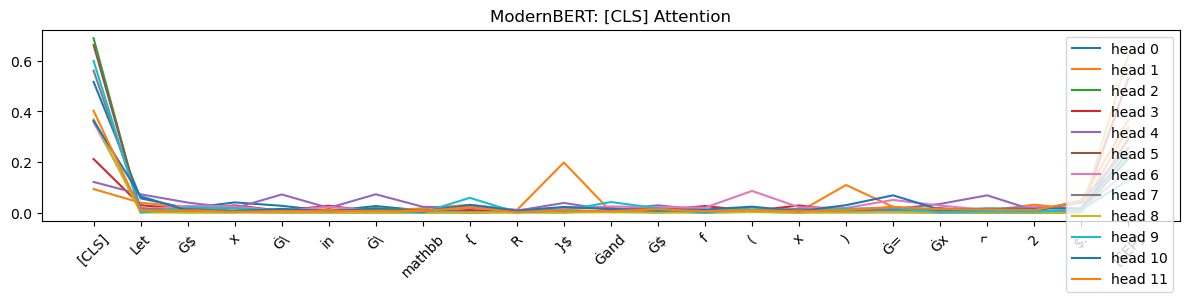

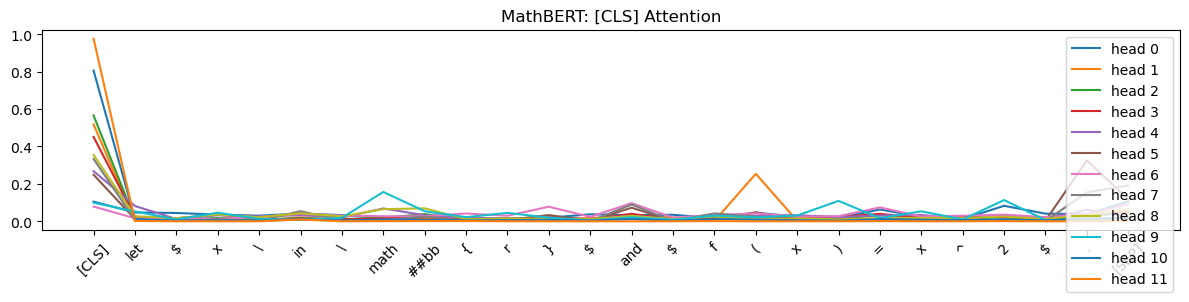

In [100]:
import matplotlib.pyplot as plt

def plot_attention(att, title, tokenizer, input_ids):
    cls_attention = att[:, 0, :]  # Attention from [CLS] token to others
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())

    fig, ax = plt.subplots(figsize=(12, 3))
    for head in range(cls_attention.shape[0]):
        ax.plot(cls_attention[head].cpu().numpy(), label=f'head {head}')
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45)
    ax.set_title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot ModernBERT
plot_attention(modern_att, "ModernBERT: [CLS] Attention", modern_tokenizer, modern_input['input_ids'])

# Plot MathBERT
plot_attention(math_att, "MathBERT: [CLS] Attention", math_tokenizer, math_input['input_ids'])


Here we consider different attention heads and what they "think" is important for our model. Each attention head in BERT is like a separate reader or lens that looks at the input text from a different perspective. Every head computes attention scores differently. Each one can focus on different patterns, like:
 - Word order
 - Syntax (e.g., subject–verb relationships)
 - Meaning (e.g., mathematical symbols, equations)
 - Long-range dependencies

Think of it like 12 analysts reading the same sentence — each focusing on a different detail.

[CLS] Token Role [CLS] is used by BERT to summarize the meaning of the entire sentence.
The attention pattern from [CLS] reveals what the model “thinks is important” when building that summary.

🟠 ModernBERT Plot
Observation	Meaning
Most heads spike attention at [CLS] itself	The model is unsure what to focus on — so it just attends to itself.
Very low attention to math content like f(x), \\mathbb{R}	Indicates ModernBERT doesn’t understand the structure or meaning of math notation.
Tokens like $, +, {, } are mostly ignored or scattered	These may be seen as punctuation or meaningless noise.
Conclusion: ModernBERT doesn’t recognize mathematical syntax as meaningful and struggles to form useful sentence-level embeddings for math.

🔵 MathBERT Plot 
Observation	Meaning
Multiple heads show spikes on math tokens like math, ##bb, f, x, ^	MathBERT has learned to attend to math components as meaningful parts of the sentence.
It pays attention to subwords like math, ##bb, and math symbols	Indicates tokenization and semantic understanding of LaTeX-style math is better.
Higher diversity across heads	Each attention head seems to specialize more than in ModernBERT.

Conclusion: MathBERT is actively focusing on key math expressions. Its [CLS] token "learns" from the real structure of the input, which makes it excellent for sentence-level math understanding and retrieval.

🧠 Summary Table
| Feature             | **ModernBERT**                 | **MathBERT**                                 |
| ------------------- | ------------------------------ | -------------------------------------------- |
| Attention sharpness | Weak / self-looped             | Focused on math sub-tokens                   |
| Token awareness     | Treats math tokens as noise    | Recognizes math syntax (e.g., `f(x)`, `x^2`) |
| Semantic alignment  | Poor alignment to math content | Strong alignment — useful for retrieval      |
| Diversity of heads  | Redundant or flat              | More specialized per head                    |
